In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Using Ridge Model on Test Set

In [2]:
#Loading in Testing Data
X_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [3]:
#Loading in Training Data
X_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [4]:
cols_to_drop = [
    "ID", "Case Number", "Date", "Block",
    "Beat", "District", "Ward", "Community Area", "Updated On", "Description"
]

X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

In [5]:
# Combine X and y
train = pd.concat([X_train, y_train], axis=1)

# Drop rows where y is missing
train = train.dropna(subset=['Location'])

# Split back
X_train = train.drop(columns=['Location'])
y_train = train['Location']

In [6]:
train = pd.concat([X_train, y_train], axis=1)

# Drop rows with missing values anywhere
train_clean = train.dropna()

# Split back into X and y
X_train_clean = train_clean.iloc[:, :-1]   # all but last column
y_train_clean = train_clean.iloc[:, -1]    # last column 

In [7]:
#Defining features for one hot encoding 
categorical_features = ["IUCR", "Primary Type", "FBI Code"]
numeric_features = ["Year"]
binary_features = ["Arrest", "Domestic"]   # already numeric (0/1)
allowed = categorical_features + numeric_features + binary_features
X_train = X_train[allowed].copy()
X_test  = X_test[allowed].copy()

In [8]:
all_model_features = categorical_features + numeric_features + binary_features

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"   # Do not keep other columns!
)

In [9]:
import ast

y_train = y_train.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
y_test  = y_test.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [11]:
def convert_location_series(series):
    def parse_value(x):
        if isinstance(x, str):
            return ast.literal_eval(x)  # Convert string to tuple
        return x
    
    coords = series.apply(parse_value)
    df_coords = pd.DataFrame(coords.tolist(), columns=['Latitude', 'Longitude'], index=series.index)
    return df_coords

# Apply
y_train_clean = convert_location_series(y_train)

print(y_train_clean.head())

    Latitude  Longitude
0  41.993262 -87.655488
1  41.765453 -87.628746
2  41.939262 -87.713357
4  41.882389 -87.624375
5  41.895974 -87.673255


In [20]:
y_test_clean = convert_location_series(y_test['Location'])

In [21]:
print(y_test_clean.head())

    Latitude  Longitude
0  41.893281 -87.627552
1  41.895515 -87.710559
2  41.653746 -87.599938
3  42.012044 -87.663078
4  41.739101 -87.559069


In [15]:
best_ridge_model = MultiOutputRegressor(Ridge(alpha=10.0, max_iter=5000))
ridge_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", best_ridge_model)
])

ridge_pipe.fit(X_train, y_train_clean)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [23]:
# First, drop rows with NaNs in X_test or y_test
valid_idx = X_test.index.intersection(y_test.index)  # start with matching indices
valid_idx = valid_idx.intersection(X_test.dropna().index)
valid_idx = valid_idx.intersection(y_test_clean.dropna().index)

# Keep only valid rows
X_test_clean = X_test.loc[valid_idx]
y_test_cleaned = y_test_clean.loc[valid_idx]

print("X_test_clean shape:", X_test_clean.shape)
print("y_test_cleaned shape:", y_test_cleaned.shape)

X_test_clean shape: (236575, 6)
y_test_cleaned shape: (236575, 2)


In [24]:
print(y_test_cleaned.isna().sum())
print(X_test.isna().sum())

Latitude     0
Longitude    0
dtype: int64
IUCR            0
Primary Type    0
FBI Code        0
Year            0
Arrest          0
Domestic        0
dtype: int64


In [25]:
# Predict on the reserved test set
y_test_pred = ridge_pipe.predict(X_test_clean)

# Compute overall metrics
mse = mean_squared_error(y_test_cleaned, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_cleaned, y_test_pred)
r2 = r2_score(y_test_cleaned, y_test_pred)

# Compute metrics per coordinate
lat_rmse = np.sqrt(mean_squared_error(y_test_cleaned["Latitude"], y_test_pred[:, 0]))
lon_rmse = np.sqrt(mean_squared_error(y_test_cleaned["Longitude"], y_test_pred[:, 1]))

# Print metrics
print("Final Test Set Metrics for Ridge:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Latitude RMSE: {lat_rmse:.6f}")
print(f"Longitude RMSE: {lon_rmse:.6f}")
print(f"R2 Score: {r2}")

Final Test Set Metrics for Ridge:
MSE: 0.005527
RMSE: 0.074344
MAE: 0.059620
Latitude RMSE: 0.086284
Longitude RMSE: 0.060076
R2 Score: 0.038555114332885776


Figures

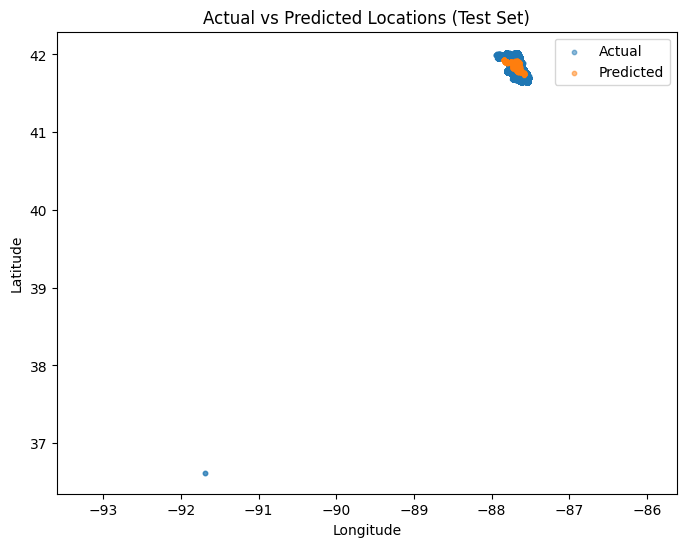

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test_cleaned['Longitude'], y_test_cleaned['Latitude'], 
            label='Actual', alpha=0.5, s=10)
plt.scatter(y_test_pred[:,1], y_test_pred[:,0], 
            label='Predicted', alpha=0.5, s=10)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Actual vs Predicted Locations (Test Set)")
plt.legend()

#Make the scale equal
plt.axis("equal")  #ensures 1 unit on x = 1 unit on y

plt.show()


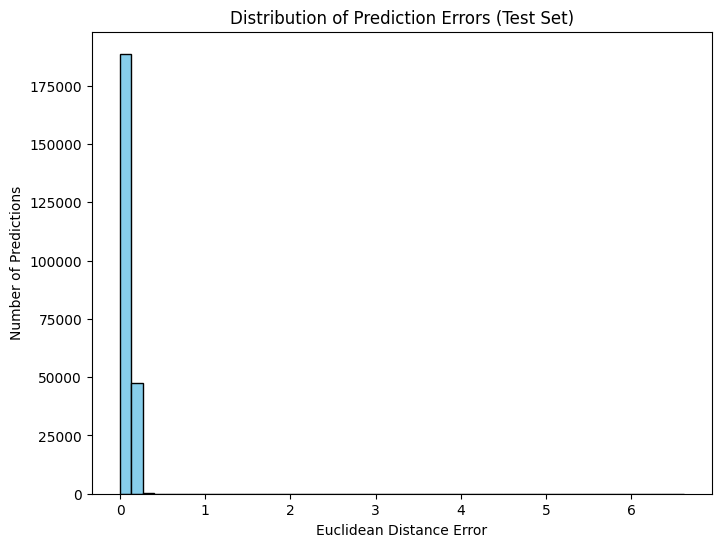

In [28]:
errors = np.sqrt((y_test_cleaned['Latitude'] - y_test_pred[:,0])**2 + 
                 (y_test_cleaned['Longitude'] - y_test_pred[:,1])**2)

plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Euclidean Distance Error")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Prediction Errors (Test Set)")
plt.show()
